# <span style='color:purple'> Imports & settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from pathlib import Path

PENALTY_RATE = 1
POSITION_MAPPING = {'PG':1, 'SG':2, 'SF':3, 'PF':4, 'C':5}

from roster_lib.id_dict import pid2name, name2pid, pid2pos_bref
from roster_lib.preprocessing.loader import Loader
from roster_lib.utils.colinearity_handler import ColinearityHandler
from roster_lib.clustering.clusterer import Clusterer, METRICS_ASC
from roster_lib.constants import PREPROC_DATA_PATH

%reload_ext autoreload
%autoreload 2

Steps worth enriching later on :  
* duplicated entries (entries with most game played was kept, but it was also duplicated)  
* droping player missing is any of the dataset    

# <span style='color:blue'> Loader

### Duplicated handling

In [10]:
loader = Loader()
loader._load_raw_data()
for k,v in loader.raw_data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")
    # display(v.head(3))

Score - shape = (3131, 34) - n° duplicated index = 91
Misc - shape = (3066, 15) - n° duplicated index = 13
Defense - shape = (3045, 20) - n° duplicated index = 15
Pass - shape = (3092, 48) - n° duplicated index = 39
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [11]:
issues = []
for k,v in loader.raw_data.items():
    for psid in v[v.index.duplicated()].index.unique():
        pid = int(psid.split('_')[0])
        sid = psid.split('_')[-1]
        if psid not in issues :
            issues.append(psid)
            print(f"{k:<12} - {pid2name[pid]:<20} - {sid} ({psid})") 

Score        - Jalen Jones          - 2017-18 (1627883_2017-18)
Score        - Delon Wright         - 2017-18 (1626153_2017-18)
Score        - Alfonzo McKinnie     - 2017-18 (1628035_2017-18)
Score        - Jakob Poeltl         - 2017-18 (1627751_2017-18)
Score        - Charles Cooke        - 2017-18 (1628429_2017-18)
Score        - ETwaun Moore         - 2017-18 (202734_2017-18)
Score        - Fred VanVleet        - 2017-18 (1627832_2017-18)
Score        - Cheick Diallo        - 2017-18 (1627767_2017-18)
Score        - Pascal Siakam        - 2017-18 (1627783_2017-18)
Score        - Darius Miller        - 2017-18 (203121_2017-18)
Score        - CJ Miles             - 2017-18 (101139_2017-18)
Score        - Jameer Nelson        - 2017-18 (2749_2017-18)
Score        - Lucas Nogueira       - 2017-18 (203512_2017-18)
Defense      - Quincy Pondexter     - 2014-15 (202347_2014-15)
Defense      - Corey Brewer         - 2017-18 (201147_2017-18)


In [13]:
# for psid in issues :
#     print(pid2name[int(psid.split('_')[0])])
#     for k,v in loader.raw_data.items():
#         if len(v.loc[psid].shape)>1 :
#             print(f"    {k}")

In [61]:
## Displays duplicated entries in "Score"

# for pl in issues :
#     print(f"{pid2name[int(pl.split('_')[0])]} - {pl.split('_')[-1]}")
#     display(data['Score'].loc[pl])

In [14]:
loader._handle_duplicated()

for k,v in loader.preproc_data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")

Score - shape = (3040, 34) - n° duplicated index = 0
Misc - shape = (3053, 15) - n° duplicated index = 0
Defense - shape = (3030, 20) - n° duplicated index = 0
Pass - shape = (3053, 48) - n° duplicated index = 0
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [15]:
_tmp_list = []
partly_missing = []
for k,v in loader.preproc_data.items():
    for kk,vv in loader.preproc_data.items():
        n_missing = 0
        for id in v.index :
            if id not in vv.index:
                n_missing += 1
                if not id in partly_missing:
                    partly_missing.append(id)
        _tmp_list.append({'from': k , 'to': kk, 'missing':n_missing})
pd.DataFrame(_tmp_list).pivot(index = 'from', columns = 'to', values = 'missing')

to,Defense,Misc,Pass,Rebound,Score
from,,,,,
Defense,0,0,0,0,8
Misc,23,0,0,0,13
Pass,23,0,0,0,13
Rebound,23,0,0,0,13
Score,18,0,0,0,0


### Merging data

In [19]:
# Check if all minutes are relevant between datasets
# Impossible due to duplicate indices
_time_df = pd.concat([ v[['MIN']].rename(columns = {'MIN':k}) for k,v in loader.preproc_data.items() ], axis = 1)

_time_df['delta'] = _time_df.max(axis=1) - _time_df.min(axis = 1)
_time_df['name'] = [pid2name[int(x.split('_')[0])] for x in _time_df.index]
_time_df.sort_values('delta', ascending= False).head(10)

,Score,Misc,Defense,Pass,Rebound,delta,name
pidSzn,,,,,,,
202713_2017-18,5.0,5.0,3.3,4.9,3.3,1.7,Kyle Singler
1628451_2017-18,6.7,6.7,8.1,6.7,8.1,1.4,Jacob Wiley
201587_2019-20,23.3,23.3,22.4,23.0,22.4,0.9,Nicolas Batum
1627733_2019-20,18.1,18.1,18.7,17.8,18.7,0.9,Dragan Bender
2199_2016-17,28.0,28.0,27.3,27.6,27.3,0.7,Tyson Chandler
1627761_2017-18,17.7,17.7,18.2,17.5,18.2,0.7,DeAndre Bembry
2030_2014-15,9.6,9.6,10.2,9.5,10.2,0.7,Kenyon Martin
2555_2017-18,5.1,5.1,4.4,5.0,4.4,0.7,Nick Collison
1629627_2019-20,28.2,28.2,27.5,27.8,27.5,0.7,Zion Williamson


### Data quality

In [20]:
_dupl_df =  pd.concat([v.drop(columns = ['MIN', 'GP', 'Season']) for v in loader.preproc_data.values()], axis = 1)
n_dupl = _dupl_df.index.duplicated().sum()
n_any_na = _dupl_df.isna().any(axis = 1).sum()
print(f"n° duplicated : {n_dupl} | n° line with n.a. : {n_any_na}")

n° duplicated : 0 | n° line with n.a. : 290


In [21]:
_dupl_df.isna().sum(axis = 0).sort_values()

OFF_LOOSE_BALLS_RECOVERED      0
SCREEN_AST_PTS                 0
PAINT_TOUCH_PASSES             0
DRIVE_PF_PCT                   0
DRIVE_PF                       0
                            ... 
D_FGM                         23
FREQ                          23
OPP_PTS_FB                    23
FG2_PCT                       36
FG3_PCT                      261
Length: 127, dtype: int64

In [23]:
display(loader.preproc_data['Score'][loader.preproc_data['Score']['FG3_PCT'].isna()][['FG3A_FREQUENCY', 'FG3A','FG3_PCT']].sort_values('FG3A').head(3))
display(loader.preproc_data['Score'][loader.preproc_data['Score']['FG2_PCT'].isna()][['FG2A_FREQUENCY', 'FG2A','FG2_PCT']].sort_values('FG2A').head(3))


,FG3A_FREQUENCY,FG3A,FG3_PCT
pidSzn,,,
203945_2014-15,0.0,0.0,NaN
201582_2014-15,0.0,0.0,NaN
1905_2014-15,0.0,0.0,NaN


,FG2A_FREQUENCY,FG2A,FG2_PCT
pidSzn,,,
203958_2014-15,0.0,0.0,NaN
203479_2014-15,0.0,0.0,NaN
203925_2015-16,0.0,0.0,NaN


In [24]:
max_time = 0
for pl in partly_missing:
    for v in loader.preproc_data.values():
        if pl in v.index :
            if v.loc[pl,'MIN'] > max_time :
                max_time = v.loc[pl,'MIN']
max_time

np.float64(9.8)

In [27]:

loader.df['position'].value_counts().sort_index()

position
1.0    594
2.0    680
3.0    524
4.0    626
5.0    584
Name: count, dtype: int64

# <span style ='color:chartreuse'>ColinearityHandler

In [162]:
chs_v = sorted([int(f.split("_")[1].split(".")[0][1:]) for f in os.listdir(PREPROC_DATA_PATH / 'clustering') if 'features' in f])
chs_positions = [True, False, True, False, True, True] 
chs_positions = chs_positions+ [True] * (len(chs_v) - len(chs_positions))
for v, pos in zip(chs_v, chs_positions) :
    _ch = ColinearityHandler(feature_version= v, use_positions=pos)
    print(len(_ch.incl), 'position' in _ch.incl) 
    

68 True
67 False
29 True
28 False
29 True
68 True


In [153]:
# with open("/home/admin/code/arnaud-odet/7_PhD/Roster/preproc_data/clustering/features_v1.json", "r") as f:
#     data = json.load(f)
# data['incl']

In [163]:
colinearity_handler = ColinearityHandler(use_positions=True)
print(len(colinearity_handler.incl), 'position' in colinearity_handler.incl)
colinearity_handler.compute_vifs()
for k,v in colinearity_handler.vifs.items():
    print(f"Feature Selection : {k}")
    display(v.round(2).head(5))

Initial number of features : 31
Top VIF = 380.2 - droping feature TS_PCT
Top VIF = 145.9 - droping feature PTS_PAINT
Top VIF = 116.9 - droping feature EFG_PCT
Top VIF = 82.1 - droping feature FG2A
Top VIF = 45.3 - droping feature FG2_PCT
Top VIF = 41.7 - droping feature USG_PCT
Top VIF = 34.5 - droping feature FG3A
Top VIF = 23.1 - droping feature PTS_OFF_TOV
Top VIF = 22.9 - droping feature PAINT_TOUCH_FG_PCT
Top VIF = 19.8 - droping feature CATCH_SHOOT_FG_PCT
Top VIF = 18.6 - droping feature PTS_2ND_CHANCE
Top VIF = 17.5 - droping feature PTS_PER_TOUCH
Top VIF = 13.0 - droping feature FG2A_FREQUENCY
Top VIF = 9.7 - stopping features exclusion with 18 feature retained
Initial number of features : 12
Top VIF = 96157.8 - droping feature DIST_MILES
Top VIF = 295.0 - droping feature DIST_MILES_OFF
Top VIF = 289.7 - droping feature AVG_SPEED
Top VIF = 141.4 - droping feature AVG_SPEED_DEF
Top VIF = 14.0 - droping feature DIST_MILES_DEF
Top VIF = 6.9 - stopping features exclusion with 7 fea

,features,vif_index
0,EFG_PCT,59.28
1,USG_PCT,54.54
6,FG2_PCT,41.82
22,AST_RATIO,37.80
3,PTS_PAINT,37.53


Feature Selection : excl


,features,vif_index
44,D_FG_PCT,1636.13
24,FG2A_FREQUENCY,1406.78
53,SCREEN_ASSISTS,728.40
54,SCREEN_AST_PTS,720.79
38,AVG_SPEED_DEF,692.17


Feature Selection : autoexcl


,features,vif_index
24,AVG_SPEED_OFF,103.61
71,position,31.95
27,DEF_RIM_FG_PCT,30.12
20,LOOSE_BALLS_RECOVERED,26.77
6,DRIVE_PTS,25.62


# <span style ='color:orange'> Clusterer

### <span style = 'color:chartreuse'> Results

<sopan style = 'color:cyan'>Findings and comments : </span>
* From various attemps before `v1`, Centers and Power Forwards are more separated, whereas PG, SG and SF are grouped together 
* `v1` uses listed positions
* `v2` does not
* `v3` uses a considerably reduced MANUAL_INCLUSION of features, with listed positions (`v4` without)
* `v5` introduces `n_runs` (5 repeats, same parameters than `v4`)
* <span style = 'color : red'> Attention </span> possible errors in `position` inclusion in version 1 to 5, may be missing for `incl` scenarios
* `v6` uses `v1` features with `n_runs = 5`, set `evrs` from 0.6 and `n_clust` up to 20. Re-introduction of `agg_single`
* `v7` introduces `SilhouetteW` score with `n_clust` up to 16



In [76]:
clusterer = Clusterer(alpha= 0.5, beta = 0)
clusterer.last_version

6

In [77]:
cdf = clusterer.rdf.copy()
# cdf = clusterer.load_results(3)
display(cdf.sort_values(by = 'evr_e_w_silhouette', ascending=False).head(5))

,feature_selection,method,scaling,evr,n_PC,n_clust,silhouette,davies_bouldin,calinski_harabasz,entropy,population_std,e_w_silhouette,evr_e_w_silhouette
4428,autoexcl,agg_ward,robust,0.6,6,2,0.552416,1.303356,1254.754261,0.576243,0.363032,0.419343,0.419343
4410,autoexcl,kmeans,robust,0.6,6,2,0.585567,1.161065,1402.558178,0.506217,0.387899,0.416625,0.416625
2520,excl,kmeans,robust,0.6,5,2,0.539340,1.163628,1506.165684,0.594306,0.356117,0.415784,0.415784
2538,excl,agg_ward,robust,0.6,5,2,0.546723,1.164106,1356.406879,0.535105,0.377992,0.399933,0.399933
630,incl,kmeans,robust,0.6,3,2,0.537615,0.872130,1754.785763,0.519404,0.362234,0.387458,0.387458


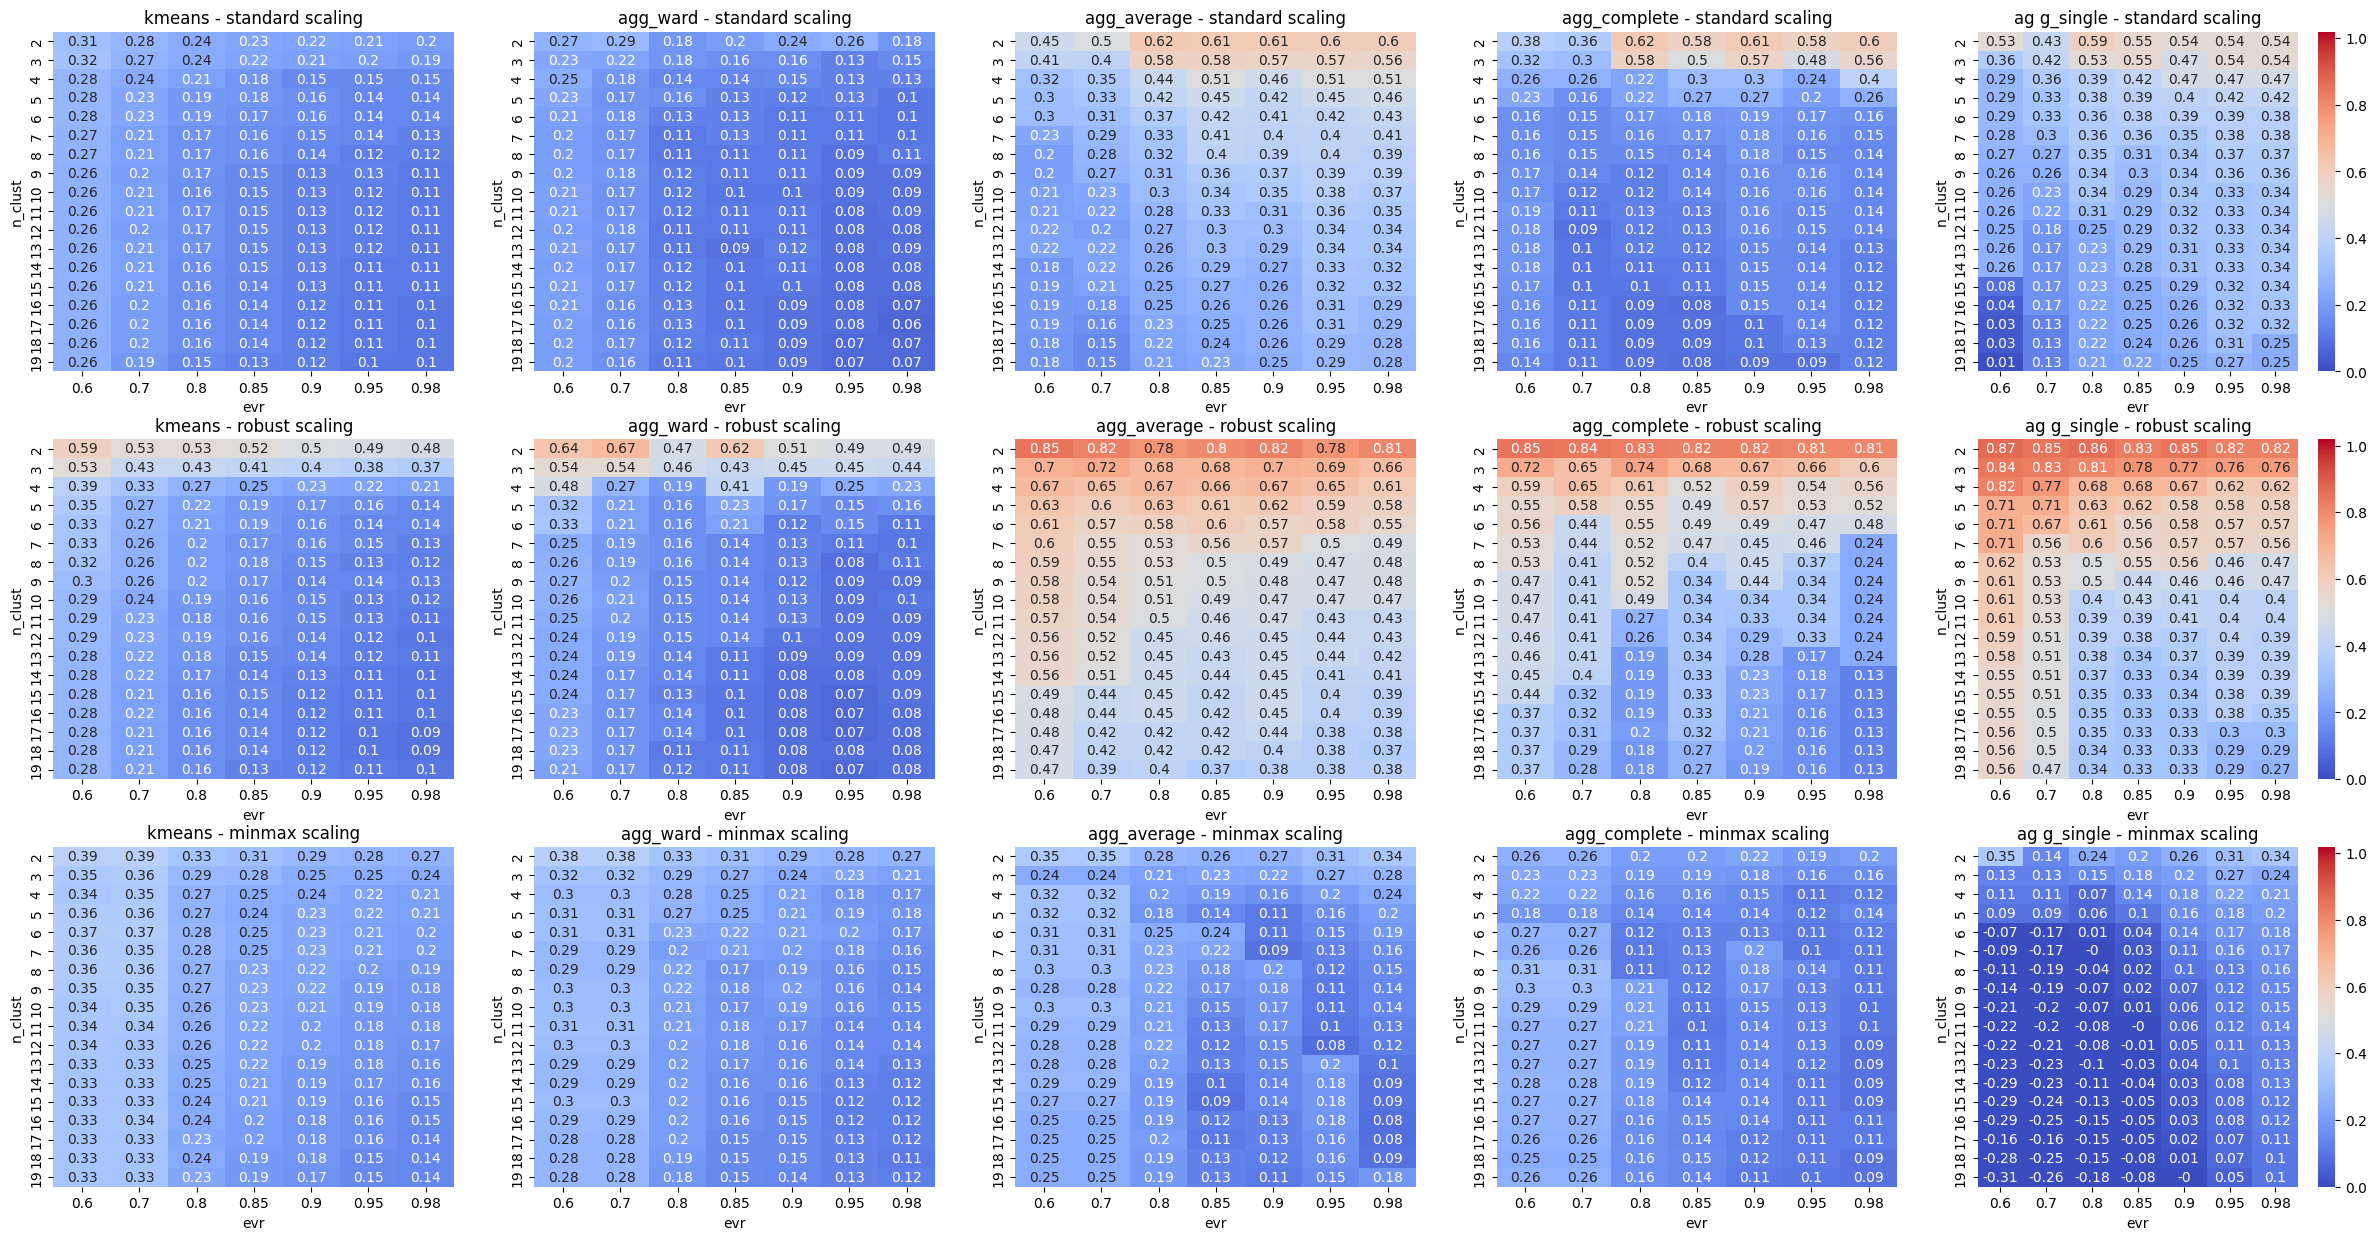

In [ ]:
scalings = cdf['scaling'].unique()
methods = cdf['method'].unique()

metric = 'silhouette'
# metric = 'silhouette_W'
# metric = 'e_w_silhouette'
# metric = 'evr_e_w_silhouette'

heatmap_kw = {'cmap': 'coolwarm', 'vmin': max(cdf[metric].min()-0.15,0), 'vmax':cdf[metric].max()+0.15, 'annot': True}
fig, axs = plt.subplots(len(scalings),len(methods),figsize = (6*len(methods),5* len(scalings)));
_cdf = cdf.groupby(['method','scaling','evr','n_clust']).agg({'n_PC':'first', metric:'max'}).reset_index()
for i, ax in enumerate(axs.flatten()) :
    method = methods[i % len(methods)]
    scaling = scalings[i // len(methods)]
    sns.heatmap(data= _cdf[(_cdf['method']==method)&(_cdf['scaling']==scaling)].pivot(index = 'n_clust', columns = ['evr'], values = metric).round(2), 
                ax = ax, **heatmap_kw, cbar = (i % len(methods)) == len(methods) -1);
    ax.set_title(f"{method} - {scaling} scaling");


### <span style = 'color:yellow'>Metrics

#### Display data 

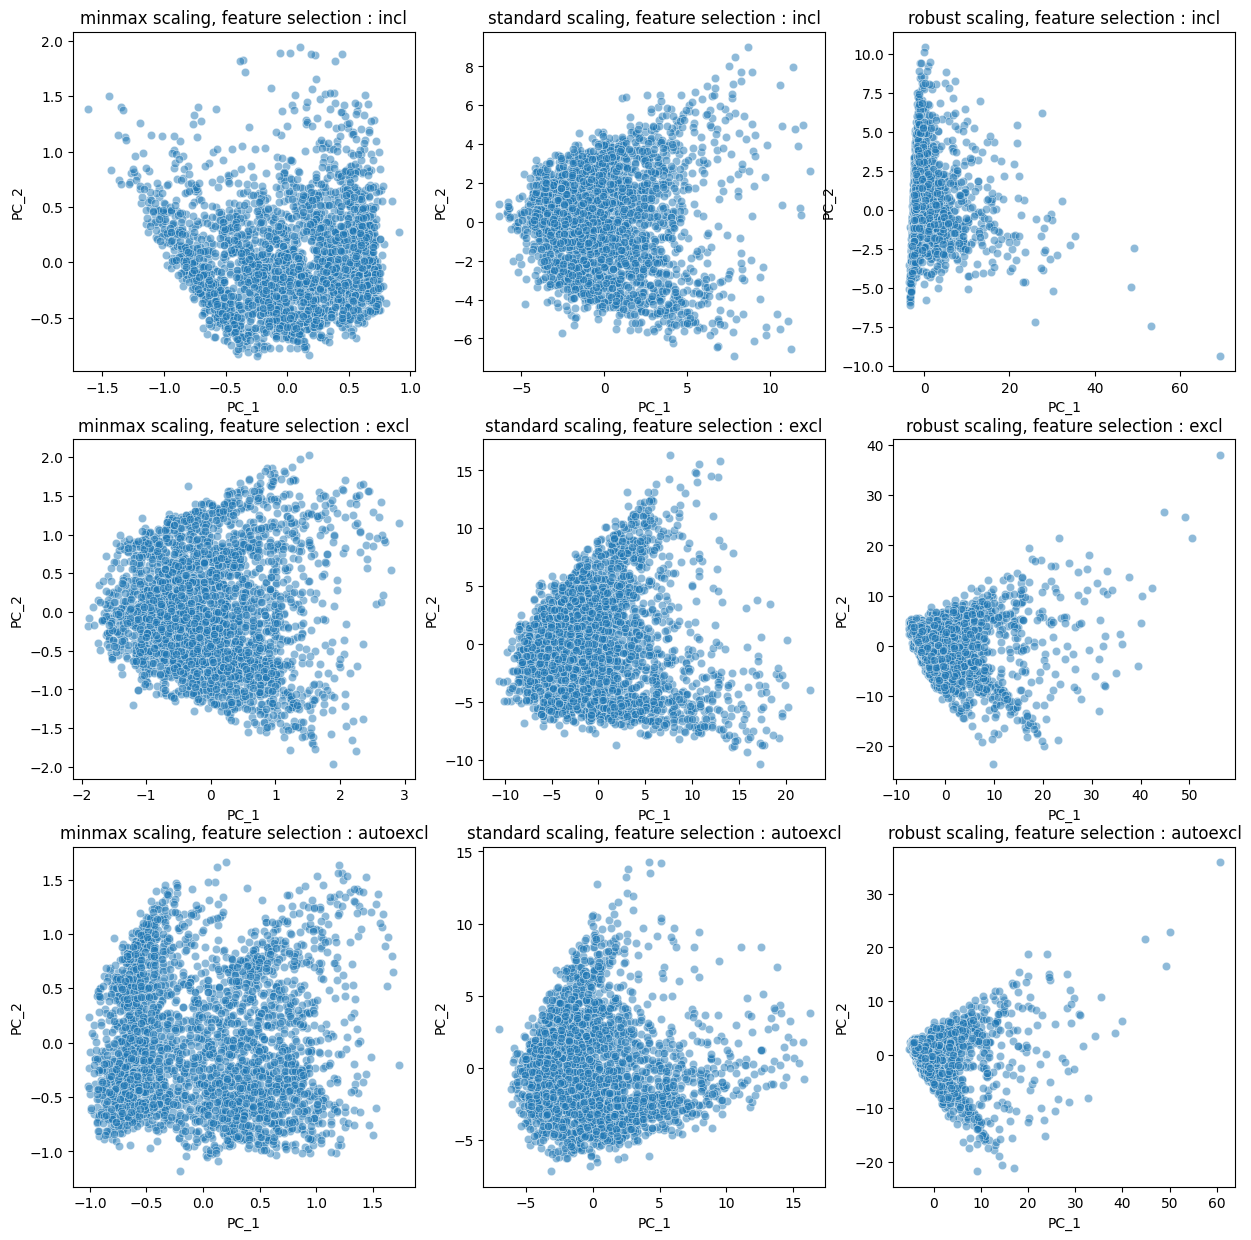

In [5]:
clusterer.plot_data()

In [6]:
for fs, thres in zip(['incl','excl','autoexcl'], [40,40, 36]):
    _sdf = clusterer.get_scaled_data(scaling='robust', feature_selection=fs)
    display(_sdf[_sdf['PC_1'] > thres])

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29
Andre Drummond_2017-18,49.311270,-2.439335,-4.716864,-5.912972,-1.988867,-0.762189,-2.684410,-2.884165,3.422559,0.403830,...,-0.539918,-0.339861,0.628332,-0.015162,0.950448,-0.146067,-0.379790,-0.040100,-0.376790,0.059275
DeAndre Jordan_2017-18,48.525156,-4.932666,-5.194094,-5.431028,0.454382,-0.998317,-3.692359,-3.483101,2.878046,-0.442690,...,-1.038938,0.086020,0.657494,-0.507777,-0.492173,-0.789298,-0.526530,0.049833,0.131104,0.022823
Enes Kanter_2017-18,53.201606,-7.420678,-9.073248,-6.919385,0.586022,-0.412983,-6.201624,-4.190781,2.190373,-1.359517,...,-0.340660,-1.105004,-0.289530,-0.248695,0.087861,-0.240036,0.040856,0.052627,0.127173,-0.066851
Steven Adams_2017-18,69.425966,-9.340360,-11.203402,-8.197198,1.222020,-1.943977,-5.932951,-4.785808,2.884499,-1.073858,...,0.700677,0.330349,-0.137801,-0.039249,0.814879,0.134170,0.732643,0.130714,0.220777,0.233088


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_107,PC_108,PC_109,PC_110,PC_111,PC_112,PC_113,PC_114,PC_115,PC_116
Andre Drummond_2017-18,50.527884,21.440004,16.219764,6.012722,9.702180,-7.888475,-0.744184,-3.165931,1.092535,0.776924,...,0.093789,-0.109424,0.055677,0.061061,0.165586,0.075163,-0.083360,0.090748,-0.040577,0.000029
DeAndre Jordan_2017-18,44.799460,26.635545,17.452568,4.540911,8.713214,-8.701607,-1.656278,-3.629721,1.455321,2.462922,...,-0.111711,0.015935,-0.005339,0.036933,-0.034257,0.071661,-0.007229,0.024727,0.002671,0.000041
Dwight Howard_2017-18,42.371370,11.587099,6.824589,9.791593,2.553499,-6.897755,-0.194769,0.595807,2.297953,-0.563341,...,-0.159031,-0.003521,0.093581,0.004385,-0.063372,-0.013775,0.121244,-0.096727,0.044873,0.000028
Enes Kanter_2017-18,49.029823,25.676962,15.614283,13.580379,1.050057,-10.935294,-0.996837,-7.314732,1.725845,0.747870,...,-0.096898,-0.013728,0.068345,0.006337,-0.127944,-0.023988,-0.112909,0.035884,0.047787,0.000008
Steven Adams_2017-18,56.231422,38.057169,22.846221,7.741419,4.516426,-11.275454,-3.451263,-13.900343,-2.256861,2.470303,...,-0.197948,0.058261,-0.089383,0.077230,0.094387,0.065578,0.084899,0.000400,-0.081692,0.000045
Andre Drummond_2018-19,40.296603,9.990925,8.474000,1.917903,10.226069,-8.237436,0.969754,2.444964,2.230723,1.608030,...,0.035529,-0.008115,0.041811,0.021668,0.287494,0.038822,-0.014717,-0.035146,0.049447,0.000030


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72
Andre Drummond_2017-18,49.117337,16.473196,8.587943,10.216517,5.164782,0.044162,0.107946,-0.790190,1.956643,-3.589169,...,0.090636,-0.707221,0.042821,0.151370,-0.388948,0.114848,0.322071,-0.236436,-0.349192,-0.258051
DeAndre Jordan_2017-18,44.876854,21.501134,7.885632,10.054705,4.447787,-1.559445,2.160126,1.178171,2.000163,-3.171379,...,-0.249346,-0.016034,-0.667153,-0.155662,-0.501871,-0.033893,0.051399,0.066792,0.102618,0.053140
Dwight Howard_2017-18,39.829421,6.258073,2.269205,3.410160,8.549131,1.284281,0.155372,1.655765,1.123639,-2.213004,...,0.000619,0.236369,-0.122153,0.037256,-0.787747,-0.252656,0.095806,0.261451,0.153188,-0.084088
Enes Kanter_2017-18,49.982426,22.861027,7.228382,3.901735,12.896140,-1.138535,1.667950,0.920425,2.359958,-3.790944,...,0.040911,-0.402679,-0.313203,0.291803,-0.084106,0.420560,0.309090,-0.093397,-0.285264,0.006881
Steven Adams_2017-18,60.630849,35.850287,10.760360,6.319371,9.643737,-4.168331,1.790199,-4.008945,4.110625,-5.842806,...,-0.108950,0.329981,-0.152365,0.010339,-0.226072,0.774826,0.465617,0.129010,0.201380,-0.196742
Andre Drummond_2018-19,38.513743,4.013038,3.906439,9.958183,1.444981,0.583650,-0.983304,1.414390,1.919419,-1.539772,...,-0.028816,-0.417980,-0.142749,0.565907,0.227368,0.177109,0.235094,-0.164291,-0.060336,-0.259562


#### Highest score per metric

In [78]:
target_n_clust = 6 # Set to 2 to ignore
target_evr = 0.6 # Set to 0.4 to ignore
top_k = 10
ref_metric = 'evr_e_w_silhouette'

top_clusterings = {}
for k,v in clusterer.metrics.items():
    _tdf = cdf[(cdf['n_clust']>= target_n_clust) & (cdf['evr']>= target_evr)].sort_values(by = k, ascending= v['ascending']).head(top_k).reset_index(drop=True)
    best_index = _tdf.sort_values(by = ref_metric, ascending=False).index[0]
    params = []
    for index,row in _tdf.iterrows():
        params.append({'feature_selection': row['feature_selection'], 'method': row['method'], 'scaling':row['scaling'], 'evr':row['evr'], 'n_clust':row['n_clust']})
    top_clusterings[k] = {'best_index':best_index, 'n_PC':_tdf.loc[best_index,'n_PC'], 'params' : params}

KeyError: 'silhouetteW'

In [ ]:
for method in clusterer.metrics.keys() :
    item = top_clusterings[method]['params'][top_clusterings[method]['best_index']]
    print(f"n_PC : {top_clusterings[method]['n_PC']:>2}, Exp Characteristics : {item}")

n_PC :  9, Exp Characteristics : {'feature_selection': 'incl', 'method': 'ag g_single', 'scaling': 'robust', 'evr': 0.8, 'n_clust': 6}
n_PC :  5, Exp Characteristics : {'feature_selection': 'excl', 'method': 'ag g_single', 'scaling': 'robust', 'evr': 0.6, 'n_clust': 16}
n_PC :  3, Exp Characteristics : {'feature_selection': 'incl', 'method': 'kmeans', 'scaling': 'minmax', 'evr': 0.7, 'n_clust': 8}
n_PC :  3, Exp Characteristics : {'feature_selection': 'incl', 'method': 'kmeans', 'scaling': 'minmax', 'evr': 0.7, 'n_clust': 15}
n_PC :  3, Exp Characteristics : {'feature_selection': 'incl', 'method': 'kmeans', 'scaling': 'minmax', 'evr': 0.7, 'n_clust': 18}


Silhouette: 0.700 | SilhouetteW: 0.660 | Davies-Bouldin: 0.230 | Calinski-Harabasz: 86.569 | Normalized Entropy : 0.011 | EW Silhouette: 0.074
Silhouette: 0.554 | SilhouetteW: 0.401 | Davies-Bouldin: 0.225 | Calinski-Harabasz: 25.206 | Normalized Entropy : 0.017 | EW Silhouette: 0.073
Silhouette: 0.303 | SilhouetteW: 0.296 | Davies-Bouldin: 1.003 | Calinski-Harabasz: 1392.643 | Normalized Entropy : 0.940 | EW Silhouette: 0.294
Silhouette: 0.311 | SilhouetteW: 0.297 | Davies-Bouldin: 0.978 | Calinski-Harabasz: 1318.702 | Normalized Entropy : 0.947 | EW Silhouette: 0.302
Silhouette: 0.288 | SilhouetteW: 0.286 | Davies-Bouldin: 0.996 | Calinski-Harabasz: 1242.372 | Normalized Entropy : 0.966 | EW Silhouette: 0.283


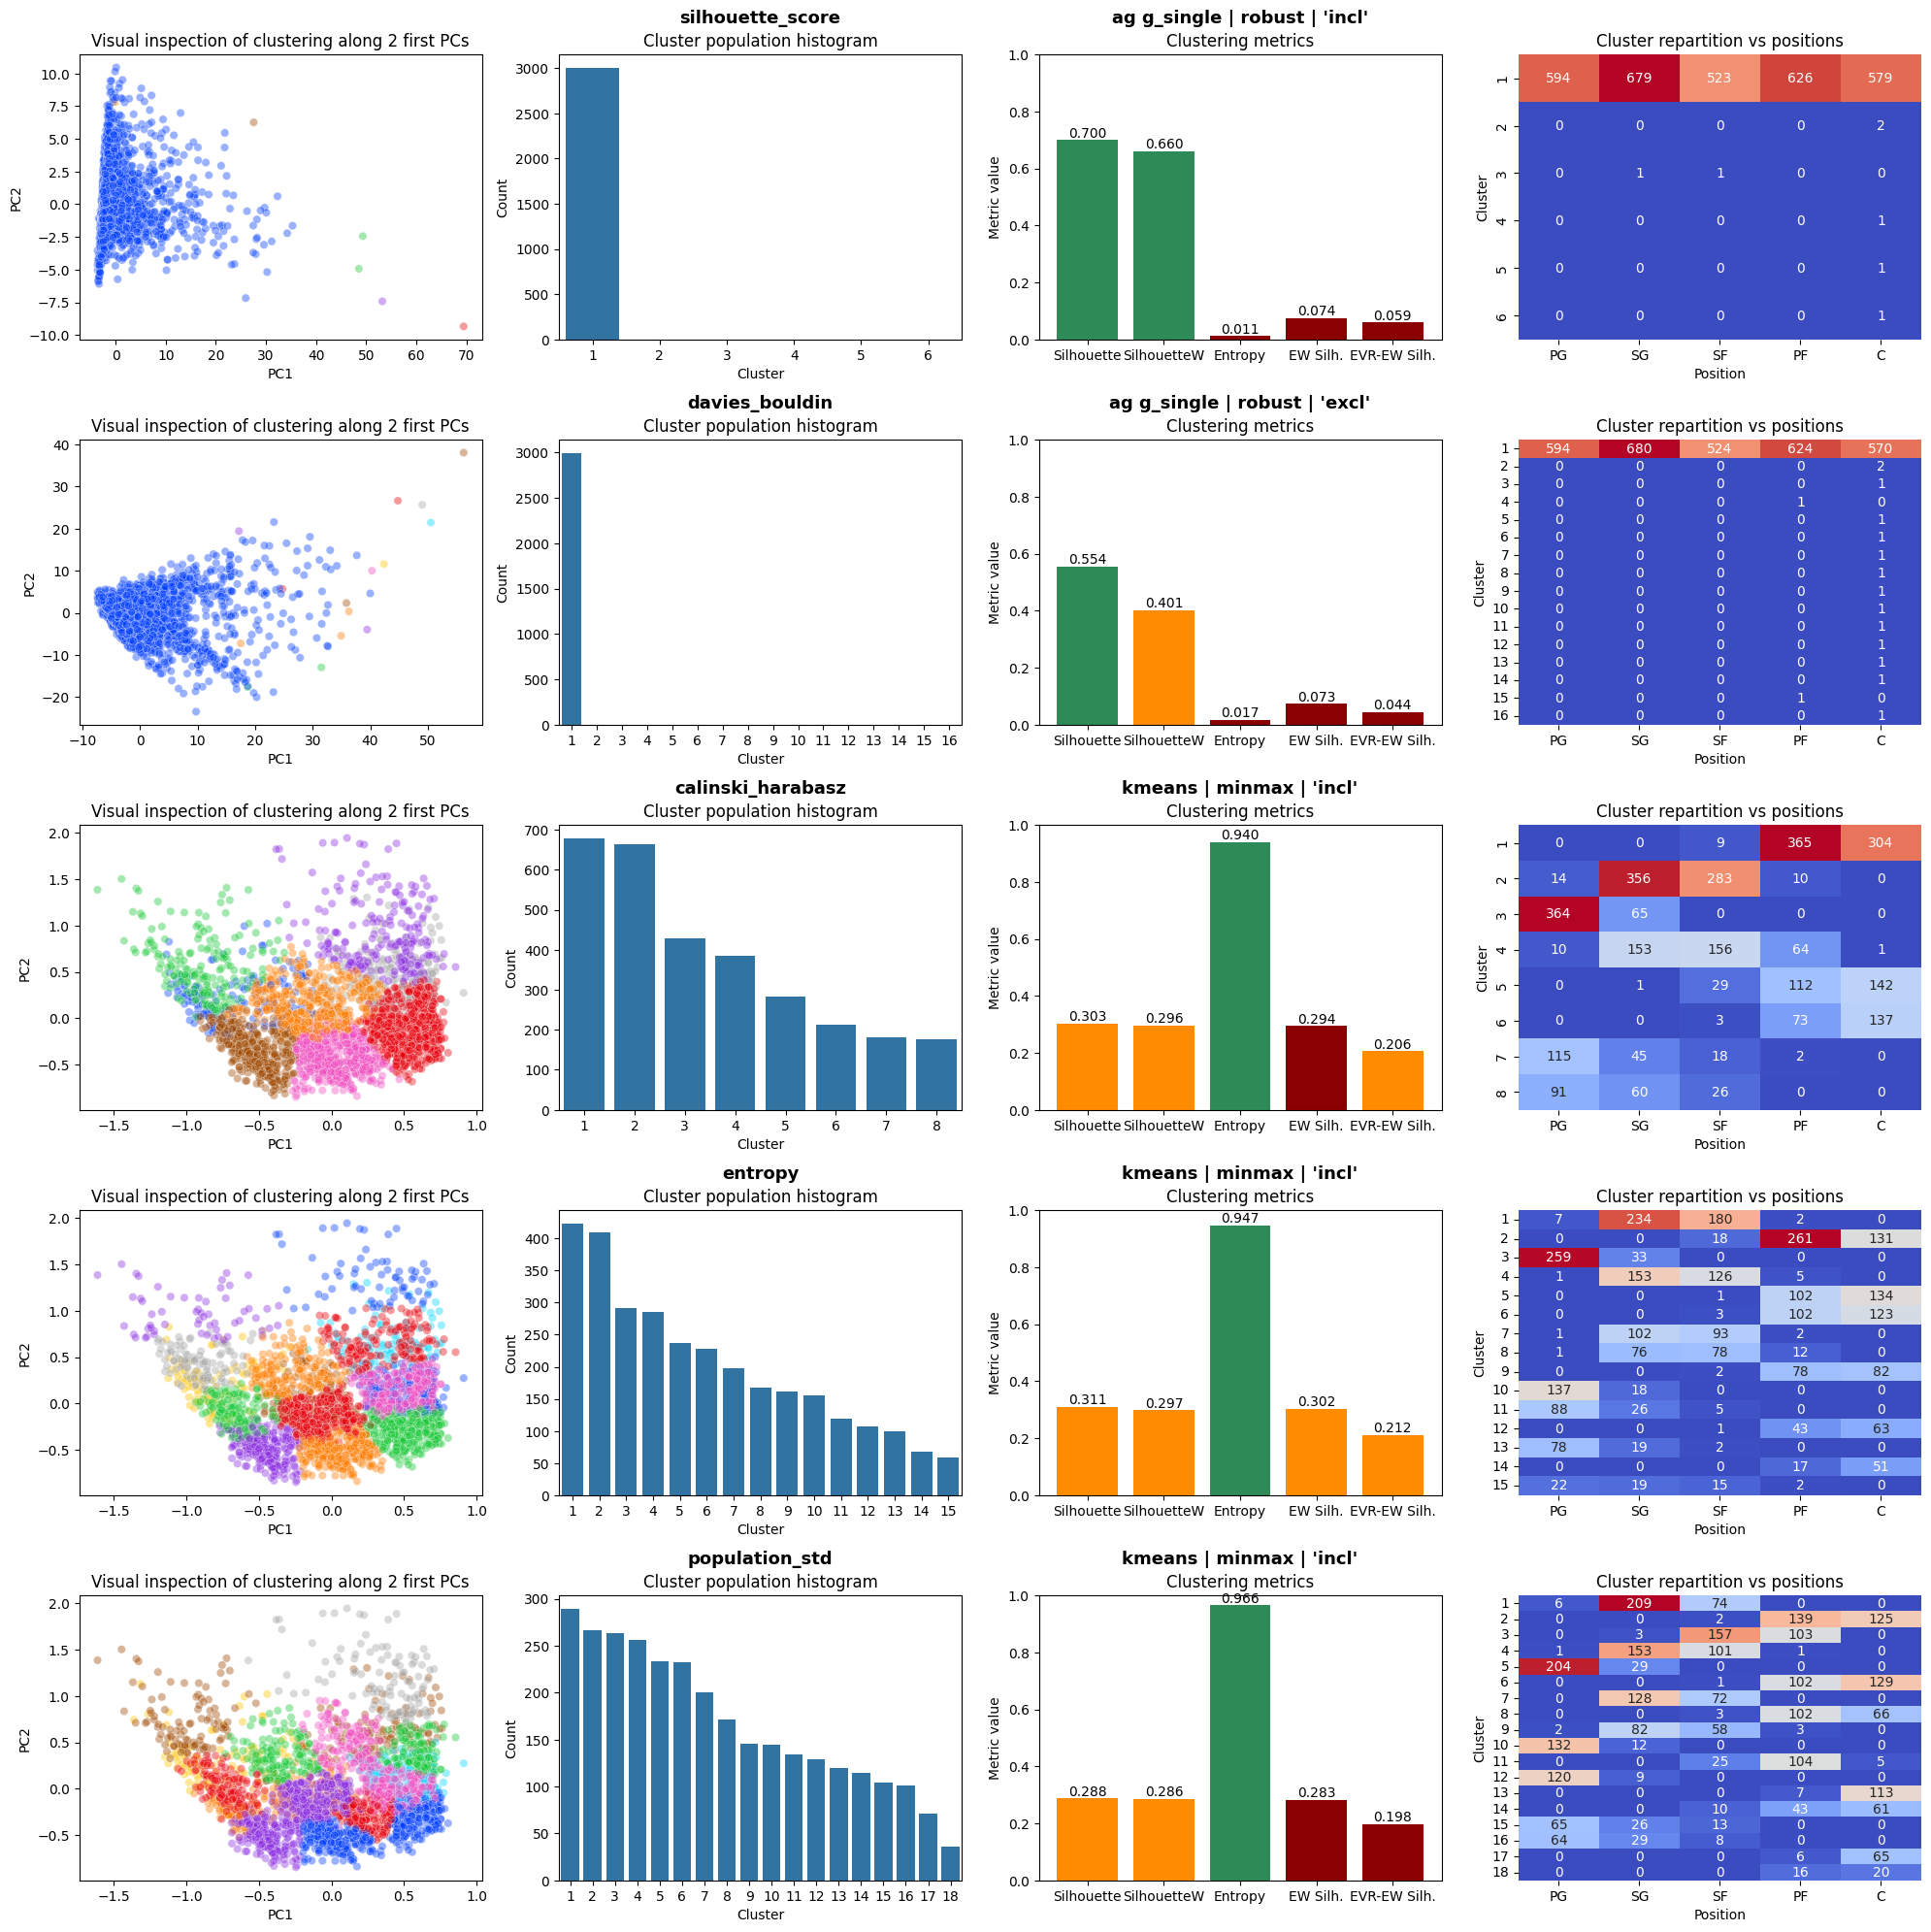

In [44]:
n_methods = len([k for k,v in top_clusterings.items() if v['n_PC'] > 1])
fig, axs = plt.subplots(n_methods,4, figsize = (20,4 * n_methods));
i = 0
annot_kws = {'xy': (0.5, 1.05), 'xytext':(0, 10), 'xycoords':'axes fraction', 'textcoords':'offset points', 'ha':'center', 'va':'bottom', 'fontsize':13, 'fontweight':'bold', 'clip_on':False}
for metric in METRICS_ASC.keys() :
    item = top_clusterings[metric]['params'][top_clusterings[metric]['best_index']]
    n_PC = top_clusterings[metric]['n_PC']
    if not n_PC == 1 :
        clusterer.plot_clustering(**item, axs =( axs[i,0], axs[i,1], axs[i,2], axs[i,3]))
        axs[i,1].annotate(f"{metric}", **annot_kws)   
        axs[i,2].annotate(f"{item['method']} | {item['scaling']} | '{item['feature_selection']}'", **annot_kws)
        i+=1
    else :
        print(f"{metric} : Required {n_PC} PC to reach EVR of {item['evr']}")
plt.tight_layout() 
plt.show() 

kmeans minmax incl
Silhouette: 0.301 | SilhouetteW: 0.292 | Davies-Bouldin: 1.016 | Calinski-Harabasz: 1391.470 | Normalized Entropy : 0.945 | EW Silhouette: 0.293


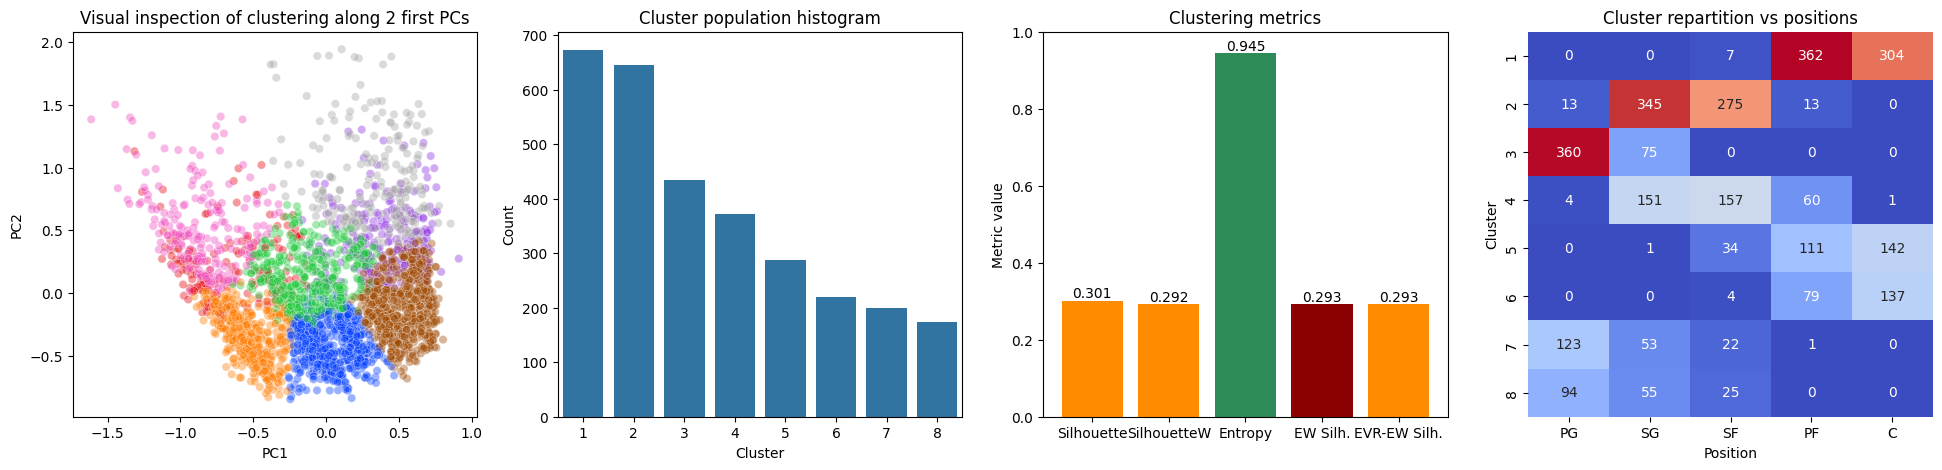

In [54]:
metric = 'calinski_harabasz'
item = top_clusterings[metric]['params'][top_clusterings[metric]['best_index']]
print(item['method'], item['scaling'], item['feature_selection'])
X_proj, labels = clusterer.plot_clustering(**item, return_data=True)


In [68]:
clusterer._compute_metrics(X_proj, labels)

{'silhouette': 0.301415308139841,
 'silhouetteW': np.float64(0.29211927157442674),
 'davies_bouldin': 1.0155951726247356,
 'calinski_harabasz': 1391.4701627465806,
 'ball_hall': np.float64(1.1365995527340365),
 'entropy': np.float64(0.9446143270344898)}

In [40]:
(np.unique_counts(labels).counts > 1).sum()

np.int64(8)

In [41]:
from sklearn.metrics import silhouette_samples, silhouette_score

def silhouette_w(X_proj, labels):
    ssa = silhouette_samples(X_proj, labels) 
    _df = pd.DataFrame(data = np.vstack([ssa, labels]).T, columns = ['silhouette','cluster'])
    _df['population'] = _df['cluster'].map(_df['cluster'].value_counts())
    _df['silhouette_weight'] = _df['silhouette'] / _df['population']
    sw_sum = _df['silhouette_weight'].sum()
    nns = (np.unique_counts(labels).counts > 1).sum()
    return sw_sum / nns

silhouette_w(X_proj, labels), silhouette_score(X_proj, labels)

(np.float64(0.292247736162736), 0.30653802158573634)

### <span style = 'color:pink'> Analysis

In [7]:
target_silhouette = 0.4
target_entropy = 0.5
target_evr = 0.6
target_n_clust = 6

target_df = cdf[(cdf['silhouette_score'] >= target_silhouette)&(cdf['entropy'] >= target_entropy)&(cdf['evr'] >= target_evr)&(cdf['n_clust'] >= target_n_clust)].sort_values(metric, ascending=False)
print(f"n° of experiments corresponding the the specified results : {target_df.shape[0]}")
target_df.head()

n° of experiments corresponding the the specified results : 0


,feature_selection,method,scaling,evr,n_PC,n_clust,silhouette_score,davies_bouldin,calinski_harabasz,entropy,population_std,entropy_silhouette,evr_e_w_silhouette


In [12]:
if target_df.shape[0] >0 :
    index = 0
    item = target_df.iloc[index][['feature_selection','method','scaling','evr','n_clust']]
    X_proj, labels = clusterer.plot_clustering(**item, return_data=True)


In [13]:
cluster_df = clusterer.colinearity_handler.df.copy()
cluster_df['id'] = [int(x.split('_')[0]) for x in cluster_df.index]
cluster_df['name'] = cluster_df['id'].map(pid2name)
cluster_df['position'] = cluster_df.index.map(pid2pos_bref)
cluster_df['season'] = [x.split('_')[1] for x in cluster_df.index]
cluster_df['cluster'] = labels
cluster_df['cluster'] = cluster_df['cluster'].map( (cluster_df['cluster'].value_counts() + cluster_df['cluster'].value_counts().index / 1000 ).rank(ascending=False)).astype(int)

In [14]:
SMALL_CLUSTER_LIMIT = 8
small_clusters = list(cluster_df['cluster'].value_counts()[cluster_df['cluster'].value_counts()<SMALL_CLUSTER_LIMIT].index)
# cluster_df['cluster'].value_counts()

In [15]:
cluster_df[cluster_df['cluster'].isin(small_clusters)][['name','position','season','cluster']].sort_values('cluster')

,name,position,season,cluster
pidSzn,,,,
203083_2017-18,Andre Drummond,C,2017-18,2
201599_2017-18,DeAndre Jordan,C,2017-18,2
201281_2017-18,Andre Ingram,SG,2017-18,3
1628421_2017-18,Devin Robinson,SF,2017-18,3
202326_2017-18,DeMarcus Cousins,C,2017-18,4
202683_2017-18,Enes Kanter,C,2017-18,5
203500_2017-18,Steven Adams,C,2017-18,6


In [16]:
cluster_df[cluster_df['cluster']==1][['name','position','season','cluster']]

,name,position,season,cluster
pidSzn,,,,
201985_2014-15,AJ Price,PG,2014-15,1
201166_2014-15,Aaron Brooks,PG,2014-15,1
203932_2014-15,Aaron Gordon,PF,2014-15,1
203940_2014-15,Adreian Payne,PF,2014-15,1
201143_2014-15,Al Horford,C,2014-15,1
...,...,...,...,...
203897_2019-20,Zach LaVine,SG,2019-20,1
1629668_2019-20,Zach Norvell Jr.,SG,2019-20,1
1629015_2019-20,Zhaire Smith,SF,2019-20,1
